In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [22]:
df = pd.read_csv('./data/CAvideos_cc50_202101.csv')

In [23]:
#indetificar los duplicado por video_id
df.duplicated(subset='video_id', keep=False)


0         True
1         True
2         True
3         True
4         True
         ...  
40876    False
40877    False
40878     True
40879    False
40880    False
Length: 40881, dtype: bool

In [24]:
# Ver cuántas veces se repite cada video
conteo_repetidos = df['video_id'].value_counts()
conteo_repetidos.head()

video_id
l_lblj8Cq0o    8
VYOjWnS4cMY    8
6ZfuNTqbHE8    8
UceaB4D0jpo    8
MGYJuETPQEg    7
Name: count, dtype: int64

In [25]:
numericas = df.select_dtypes(include=['number']).columns.tolist()
categoricas = [col for col in df.columns if col not in numericas and col != 'video_id']


In [26]:
video_id_0 = df.loc[0, 'video_id']
df[df['video_id'] == video_id_0].sort_values(by='views', ascending=True)[['title','views', 'likes', 'comment_count']]


,title,views,likes,comment_count
0,Eminem - Walk On Water (Audio) ft. Beyoncé,17158579,787425,125882
214,Eminem - Walk On Water (Audio) ft. Beyoncé,20539417,840642,124236
498,Eminem - Walk On Water (Audio) ft. Beyoncé,22702386,869304,123235
791,Eminem - Walk On Water (Audio) ft. Beyoncé,24578152,891283,125444


In [27]:
df['video_id'] = df['video_id'].astype(str)

orden_original = df[['video_id']].drop_duplicates().reset_index()

df_agrupado = df.groupby('video_id', as_index=False).agg(
    {**{col: 'mean' for col in df.select_dtypes(include=['number']).columns},
     **{col: 'first' for col in df.select_dtypes(exclude=['number']).columns if col != 'video_id'}}
)

num_cols = df.select_dtypes(include=['number']).columns.tolist()
df_agrupado[num_cols] = df_agrupado[num_cols].round(0).astype(int)

df_final = orden_original.merge(df_agrupado, on='video_id')

df_final = df_final.drop(columns='index')

df = df_final.reset_index(drop=True)


In [28]:
video_id_0 = df.loc[0, 'video_id']
df[df['video_id'] == video_id_0].sort_values(by='views', ascending=True)[['title','views', 'likes', 'comment_count']]


,title,views,likes,comment_count
0,Eminem - Walk On Water (Audio) ft. Beyoncé,21244634,847164,124699


In [29]:
df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['dias_hasta_tendencia'] = (df['trending_date'] - df['publish_time']).dt.days
df['engagement_ratio'] = (df['likes'] + df['comment_count']) / (df['views'] + 1)


In [30]:
print(df['engagement_ratio'].describe())
print(df['engagement_ratio'].quantile([0.25, 0.5, 0.75]))


count    24427.000000
mean         0.036950
std          0.034612
min          0.000000
25%          0.010862
50%          0.026394
75%          0.053079
max          0.438306
Name: engagement_ratio, dtype: float64
0.25    0.010862
0.50    0.026394
0.75    0.053079
Name: engagement_ratio, dtype: float64


In [ ]:
print(df['engagement_ratio'].describe())
print(df['engagement_ratio'].quantile([0.25, 0.5, 0.75]))




viral
0    18320
1     6107
Name: count, dtype: int64


In [ ]:
df['publish_hour'] = df['publish_time'].dt.hour
df['publish_dayofweek'] = df['publish_time'].dt.dayofweek

df['ratings_disabled'] = df['ratings_disabled'].astype(int)
df['comments_disabled'] = df['comments_disabled'].astype(int)

# Codificar categóricas simples
le_category = LabelEncoder()
df['category_id_enc'] = le_category.fit_transform(df['category_id'])

le_channel = LabelEncoder()
df['channel_title_enc'] = le_channel.fit_transform(df['channel_title'].fillna('unknown'))


In [33]:
tfidf_title = TfidfVectorizer(max_features=100)
X_title = tfidf_title.fit_transform(df['title'].fillna(''))

tfidf_tags = TfidfVectorizer(max_features=100)
X_tags = tfidf_tags.fit_transform(df['tags'].fillna(''))


In [ ]:
from scipy.sparse import hstack

X_numericas = df[['category_id_enc', 'publish_hour', 'publish_dayofweek',
                  'ratings_disabled', 'comments_disabled',
                  'dias_hasta_tendencia', 'channel_title_enc']].fillna(0)

from scipy.sparse import csr_matrix
X_num_sparse = csr_matrix(X_numericas.values)

# Concatenar matrices sparse
X = hstack([X_num_sparse, X_title, X_tags])

y = df['viral'].values


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


c:\Users\Alumnos\Documents\ds-tf\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [39]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

print(classification_report(y_test, y_pred))


Accuracy: 0.8434
F1 Score: 0.6486
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3664
           1       0.74      0.58      0.65      1222

    accuracy                           0.84      4886
   macro avg       0.80      0.75      0.77      4886
weighted avg       0.84      0.84      0.84      4886



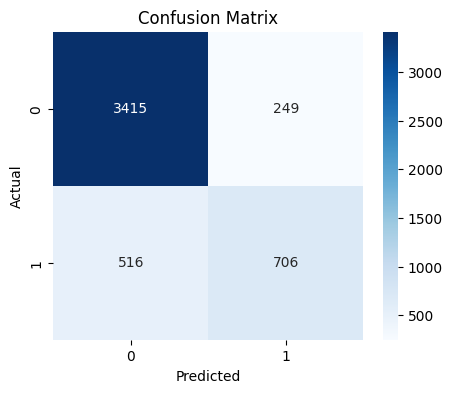


TN, FP,
FN, TP



In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nTN, FP,\nFN, TP\n")
